In [1]:
# New env

import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import random
import tensorflow as tf
from collections import deque

import cvzone
from cvzone.SelfiSegmentationModule import SelfiSegmentation

from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
dataset_path = "C:/Users/batuh/Downloads/Compressed/Dataset_3"
actions = os.listdir(dataset_path)

In [3]:
frame_count = 20

frame_width = 64
frame_height = 64

seed_constant = 86
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

segmentor = SelfiSegmentation()

In [4]:
def take_video_names(dataset_path):

  actions = os.listdir(dataset_path)
  video_paths = []
  video_labels = []

  for single_action in actions:

    videos = os.listdir(dataset_path + "/" + single_action)

    for single_video in videos:

      single_video_path = dataset_path + "/" + single_action + "/" + single_video

      video_paths.append(single_video_path)
      video_labels.append(single_action)

  print(f"There is {len(actions)} action in the dataset.")
  print(f"There is {len(video_paths)} video in the dataset\n")

  return np.array(video_paths), np.array(video_labels)

In [5]:
def zoom_at(img, zoom=1, angle=0, coord=None):
    
    cy, cx = [ i/2 for i in img.shape[:-1] ] if coord is None else coord[::-1]
    
    rot_mat = cv2.getRotationMatrix2D((cx,cy), angle, zoom)
    result = cv2.warpAffine(img, rot_mat, img.shape[1::-1], flags=cv2.INTER_LINEAR)
    
    return result

In [6]:
def video_preprocess(frame):

  resized_frame = cv2.resize(frame, (frame_height, frame_width))

  normalized_frame = resized_frame / 255

  return normalized_frame

In [23]:
def load_video (video_path):

  frames_list = []

  cap = cv2.VideoCapture(video_path)

  ok, frame = cap.read()

  video_frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

  skip_ratio = max(int(video_frame_count/frame_count), 1)

  for i in range(frame_count):

    cap.set(cv2.CAP_PROP_POS_FRAMES, i * skip_ratio)

    oke, frame = cap.read()

    if not oke:
      break

    frame = zoom_at(frame, 1.5)
    frame = frame[:,560:1360]

    # print(frame.shape)
    # cv2.imshow('asddsa', frame)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

    img_out = segmentor.removeBG(frame,(0,0,0), threshold=0.1)

    cv2.imshow('Preprocessed', img_out)
    cv2.waitKey(1)

    frame = video_preprocess(img_out)

    frames_list.append(frame)

  if len(frames_list) != frame_count:
    print(f"There is not enough number of frames in this video {video_path}")

  cap.release()

  return frames_list

In [24]:
feature_s = []

count = 0

videos, labels = take_video_names(dataset_path)

for one_video in videos:

  count = count + 1

  feature_s.append(load_video(one_video))

  print (f"{count/len(videos)*100} percent complete ")

feature_s = np.array(feature_s)

There is 4 action in the dataset.
There is 1776 video in the dataset

0.05630630630630631 percent complete 
0.11261261261261261 percent complete 
0.16891891891891891 percent complete 
0.22522522522522523 percent complete 
0.28153153153153154 percent complete 
0.33783783783783783 percent complete 
0.3941441441441441 percent complete 
0.45045045045045046 percent complete 
0.5067567567567568 percent complete 
0.5630630630630631 percent complete 
0.6193693693693694 percent complete 
0.6756756756756757 percent complete 
0.7319819819819819 percent complete 
0.7882882882882882 percent complete 
0.8445945945945946 percent complete 
0.9009009009009009 percent complete 
0.9572072072072071 percent complete 
1.0135135135135136 percent complete 
1.0698198198198199 percent complete 
1.1261261261261262 percent complete 
1.1824324324324325 percent complete 
1.2387387387387387 percent complete 
1.295045045045045 percent complete 
1.3513513513513513 percent complete 
1.4076576576576576 percent complete 

KeyboardInterrupt: 

In [9]:
print(len(feature_s))
print(type(feature_s))

1776
<class 'numpy.ndarray'>


In [10]:
le = LabelEncoder()
labels = le.fit_transform(labels)

one_hot_encoded_labels = to_categorical(labels)

In [11]:
features_train, features_test, labels_train, labels_test = train_test_split(feature_s, 
                                                                            one_hot_encoded_labels,
                                                                            test_size = 0.25,
                                                                            shuffle = True,
                                                                            random_state = seed_constant)

In [12]:
del feature_s
del labels
del count

In [13]:
def create_LRCN_model():

    model = Sequential()
    
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (frame_count, frame_height, frame_width, 3)))
    
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(32))
                                      
    model.add(Dense(len(actions), activation = 'softmax'))


    model.summary()
    
    return model

In [14]:
LRCN_model = create_LRCN_model()

print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 20, 64, 64, 16)    448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 16, 16, 16)    0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 20, 16, 16, 16)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 20, 16, 16, 32)    4640      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 20, 4, 4, 32)      0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 20, 4, 4, 32)      0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 20, 4, 4, 64)      1

In [15]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 30, mode = 'min', restore_best_weights = True)

optimizer = keras.optimizers.Adam(learning_rate=0.0001)

LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ["accuracy"])

LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 120, batch_size = 4 ,
                                             shuffle = True, validation_split = 0.2, 
                                             callbacks = [early_stopping_callback])

Epoch 1/120
267/267 [==============================] - 12s 15ms/step - loss: 1.3684 - accuracy: 0.2808 - val_loss: 1.3272 - val_accuracy: 0.3408
Epoch 2/120
267/267 [==============================] - 3s 10ms/step - loss: 1.2857 - accuracy: 0.4150 - val_loss: 1.2535 - val_accuracy: 0.4869
Epoch 3/120
267/267 [==============================] - 3s 10ms/step - loss: 1.1496 - accuracy: 0.4986 - val_loss: 1.0737 - val_accuracy: 0.5431
Epoch 4/120
267/267 [==============================] - 3s 10ms/step - loss: 1.0008 - accuracy: 0.5803 - val_loss: 0.9679 - val_accuracy: 0.5543
Epoch 5/120
267/267 [==============================] - 3s 10ms/step - loss: 0.9156 - accuracy: 0.6047 - val_loss: 0.8778 - val_accuracy: 0.6217
Epoch 6/120
267/267 [==============================] - 3s 10ms/step - loss: 0.8480 - accuracy: 0.6347 - val_loss: 0.8416 - val_accuracy: 0.6180
Epoch 7/120
267/267 [==============================] - 3s 10ms/step - loss: 0.7859 - accuracy: 0.6620 - val_loss: 0.8247 - val_accuracy

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


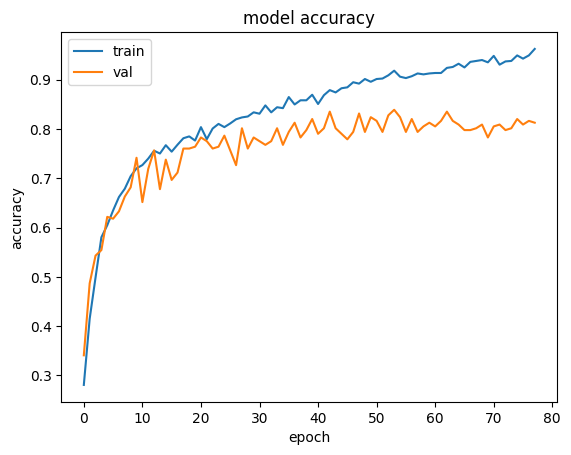

In [16]:
print(LRCN_model_training_history.history.keys())
plt.plot(LRCN_model_training_history.history['accuracy'])
plt.plot(LRCN_model_training_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

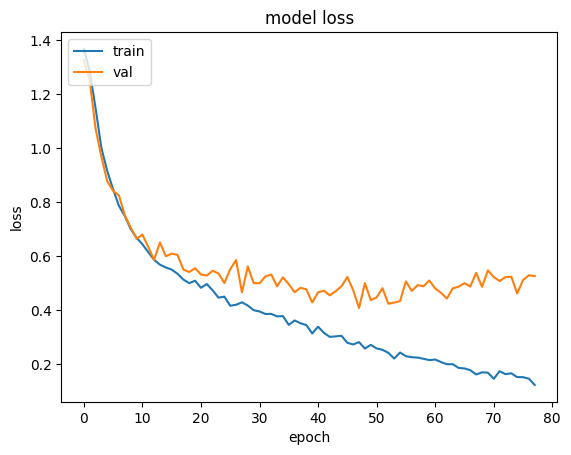

In [17]:
plt.plot(LRCN_model_training_history.history['loss'])
plt.plot(LRCN_model_training_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [18]:
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

14/14 [==============================] - 1s 30ms/step - loss: 0.4658 - accuracy: 0.7725


In [ ]:
del LRCN_model

In [19]:
Y_test = np.argmax(labels_test, axis=1)
y_pred = np.argmax(LRCN_model.predict(features_test), axis=-1)
print(classification_report(Y_test, y_pred))

print('\n')
print(actions[3])

              precision    recall  f1-score   support

           0       0.62      0.69      0.65       120
           1       0.98      0.93      0.96       119
           2       0.84      0.94      0.89       103
           3       0.63      0.51      0.57       102

    accuracy                           0.77       444
   macro avg       0.77      0.77      0.77       444
weighted avg       0.77      0.77      0.77       444



wave


In [ ]:
def create_convlstm_model():
 
    model = Sequential()
    
    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (frame_count, frame_height, frame_width, 3)))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    #model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(Flatten()) 
    
    model.add(Dense(len(actions), activation = "softmax"))
    
    model.summary()
    
    return model

In [ ]:
# Construct the required convlstm model.
convlstm_model = create_convlstm_model()

# Display the success message. 
print("Model Created Successfully!")

In [ ]:
# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics values to the model
convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs = 30, batch_size = 4,
                                                     shuffle = False, validation_split = 0.2, 
                                                     callbacks = [early_stopping_callback])

In [ ]:
print(convlstm_model_training_history.history.keys())
plt.plot(convlstm_model_training_history.history['accuracy'])
plt.plot(convlstm_model_training_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(convlstm_model_training_history.history['loss'])
plt.plot(convlstm_model_training_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

In [ ]:
# del convlstm_model

In [20]:
def predict_on_camera():

    cam = cv2.VideoCapture(0)
    
    cam_frame_list = deque(maxlen = frame_count)

    while True:

        ok, cam_frame = cam.read()
    
        if ok == True:

            img_out = segmentor.removeBG(cam_frame,(0,0,0), threshold=0.1)
        
            normalized_cam_frame = video_preprocess(cam_frame)

            cam_frame_list.append(normalized_cam_frame)

        if len(cam_frame_list) == 20:

            predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(cam_frame_list, axis = 0))[0]

            print(predicted_labels_probabilities)
            
            for i in range(len(actions)):

                if predicted_labels_probabilities[i] > 0.95 and predicted_labels_probabilities[i] < 1:
                
                    predicted_label = np.argmax(predicted_labels_probabilities)

                    predicted_class_name = actions[predicted_label]

                    cv2.putText(cam_frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            
        cv2.imshow("Frame", cam_frame)
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
            
    cam.release()

In [21]:
while True:
    
    predict_on_camera()

[5.8424518e-02 5.7326263e-04 2.2359401e-02 9.1864282e-01]
[5.7409227e-02 5.6437304e-04 2.2356844e-02 9.1966957e-01]
[5.7088610e-02 5.6476385e-04 2.2321060e-02 9.2002553e-01]
[5.6767322e-02 5.6680985e-04 2.2173414e-02 9.2049247e-01]
[5.6557480e-02 5.6054443e-04 2.2086116e-02 9.2079592e-01]
[5.6703731e-02 5.6959485e-04 2.1882663e-02 9.2084408e-01]
[5.6897815e-02 5.8050576e-04 2.1758273e-02 9.2076337e-01]
[5.7171661e-02 5.8795186e-04 2.1691633e-02 9.2054874e-01]
[5.7070564e-02 5.8428769e-04 2.1657955e-02 9.2068714e-01]
[5.7004854e-02 5.8279251e-04 2.1628419e-02 9.2078394e-01]
[5.7212275e-02 5.8928953e-04 2.1744652e-02 9.2045379e-01]
[5.7330023e-02 5.9184880e-04 2.1682620e-02 9.2039549e-01]
[5.7530571e-02 5.9939508e-04 2.1604260e-02 9.2026573e-01]
[5.7641521e-02 6.0201436e-04 2.1535760e-02 9.2022073e-01]
[5.7528906e-02 6.0138310e-04 2.1524373e-02 9.2034531e-01]
[5.7558745e-02 6.0254196e-04 2.1611776e-02 9.2022687e-01]
[5.7374340e-02 6.0246058e-04 2.1591071e-02 9.2043215e-01]
[5.7212509e-02

KeyboardInterrupt: 

In [ ]:
def predict_on_video(video_path):

    frames_list = []

    cap = cv2.VideoCapture(video_path)

    ok, frame = cap.read()

    video_frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    skip_ratio = max(int(video_frame_count/frame_count), 1)



    for i in range(frame_count):

        cap.set(cv2.CAP_PROP_POS_FRAMES, i * skip_ratio)

        oke, frame = cap.read()

        if not oke:
            break

        # frame = zoom_at(frame, 1.5)
        # frame = frame[:,560:1360]
        # print(frame.shape)
        # cv2.imshow('asddsa', frame)
        # cv2.waitKey(0)
        # cv2.destroyAllWindows()

        img_out = segmentor.removeBG(frame,(0,0,0), threshold=0.1)

        # cv2.imshow('Preprocessed', img_out)
        # cv2.waitKey(1)

        frame = video_preprocess(img_out)

        frames_list.append(frame)

    cap.release()

    return frames_list

In [ ]:
path = 'C:/Users/batuh/Downloads/Compressed/2_Second_wave/2_Second_wave/'

videos = os.listdir(path)

w = 0
c = 0
sit = 0
stand = 0

for i in videos:

    video_frames = predict_on_video(path + i)
    predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(video_frames, axis = 0))[0]
    predicted_label = np.argmax(predicted_labels_probabilities)
    predicted_class_name = actions[predicted_label]
    print(predicted_class_name)
    
    if (predicted_class_name == 'wave'):
        w = w + 1
    elif (predicted_class_name == 'clap'):
        c = c + 1
    elif (predicted_class_name == 'sit'):
        sit = sit + 1
    elif (predicted_class_name == 'stand'):
        stand = stand + 1
    
print(f'CLAP: {c}\nWAVE: {w}\nSIT: {sit}\nSTAND: {stand}')